In [84]:
import os
os.chdir('C:/Satyaki/hackathons/std_drug_effectiveness/dataset')
os.getcwd()

'C:\\Satyaki\\hackathons\\std_drug_effectiveness\\dataset'

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime,timedelta
from collections import Counter
import spacy
import en_core_web_sm
import re
import copy
from sklearn import metrics
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
df_train=pd.read_csv('train.csv',index_col='patient_id')
df_test=pd.read_csv('test.csv',index_col='patient_id')
df_train.head()

,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
patient_id,,,,,,,
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782


In [7]:
df_test.head()

,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
patient_id,,,,,,
163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


## Exploratory data analysis

In [8]:
print(df_train.shape)
print(df_test.shape)

(32165, 7)
(10760, 6)


In [9]:
print(df_train.isnull().sum())
print('--'*20)
print(df_train.isnull().sum())

name_of_drug                  0
use_case_for_drug             0
review_by_patient             0
effectiveness_rating          0
drug_approved_by_UIC          0
number_of_times_prescribed    0
base_score                    0
dtype: int64
----------------------------------------
name_of_drug                  0
use_case_for_drug             0
review_by_patient             0
effectiveness_rating          0
drug_approved_by_UIC          0
number_of_times_prescribed    0
base_score                    0
dtype: int64


In [10]:
# number of unique drugs
print('Number of unique drugs in train:',len(df_train['name_of_drug'].unique()))
print('Number of unique drugs in test:',len(df_test['name_of_drug'].unique()))

Number of unique drugs in train: 2220
Number of unique drugs in test: 1478


In [11]:
drug_count_train=Counter(df_train['name_of_drug'])
drug_count_test=Counter(df_test['name_of_drug'])
d2=pd.DataFrame()
d2['name_of_drug']=drug_count_train.keys()
d2['frequency of use']=drug_count_train.values()
d2=d2.sort_values(by='frequency of use',ascending=False)
d2.head(10)


,name_of_drug,frequency of use
71,Levonorgestrel,724
42,Etonogestrel,628
53,Ethinyl estradiol / norethindrone,547
40,Ethinyl estradiol / norgestimate,425
41,Nexplanon,397
5,Ethinyl estradiol / levonorgestrel,394
164,Phentermine,296
11,Sertraline,281
55,Escitalopram,265
338,Mirena,241


In [12]:
# number of unique use cases
print('Number of unique Ailments in train:',len(df_train['use_case_for_drug'].unique()))
print('Number of unique Ailments in test:',len(df_test['use_case_for_drug'].unique()))

Number of unique Ailments in train: 636
Number of unique Ailments in test: 461


In [13]:
# seeing the most common use cases
ailment_count_train=Counter(df_train['use_case_for_drug'])
ailment_count_test=Counter(df_test['use_case_for_drug'])

d=pd.DataFrame()
d['Ailment']=ailment_count_train.keys()
d['Number of cases']=ailment_count_train.values()
d=d.sort_values(by='Number of cases',ascending=False)
d.head(10)

,Ailment,Number of cases
2,Birth Control,5795
5,Depression,1791
15,Pain,1273
22,Anxiety,1174
20,Acne,1101
7,Bipolar Disorde,815
43,Insomnia,772
23,Obesity,727
31,Weight Loss,717
1,ADHD,627


In [14]:
# checking if all drugs present in test set are present in train set
set1=set(df_train['name_of_drug'])
set2=set(df_test['name_of_drug'])
len(set2.difference(set1))

161

In [15]:
# Converting time columns to proper format
df_train['drug_approved_by_UIC']=df_train['drug_approved_by_UIC'].apply(lambda x: datetime.strptime(x,'%d-%b-%y'))
df_test['drug_approved_by_UIC']=df_test['drug_approved_by_UIC'].apply(lambda x: datetime.strptime(x,'%d-%b-%y'))

date1_train,date2_train=df_train['drug_approved_by_UIC'].min(),df_train['drug_approved_by_UIC'].max()

df_train['drug_approved_by_UIC']=df_train['drug_approved_by_UIC'].apply(lambda x: (x-date1_train).days)
df_test['drug_approved_by_UIC']=df_test['drug_approved_by_UIC'].apply(lambda x: (x-date1_train).days)

#### Adding a feature for drug frequency

In [16]:
df_train['drug_frequency']=1
for i in df_train['name_of_drug']:
    df_train['drug_frequency']=np.where(df_train['name_of_drug']==i,drug_count_train[i],df_train['drug_frequency'])


In [17]:
df_test['drug_frequency']=1
for i in df_test['name_of_drug']:
    df_test['drug_frequency']=np.where(df_test['name_of_drug']==i,drug_count_test[i],df_test['drug_frequency'])

#### Classifying use cases with low number of occurences as rare

In [18]:
def fun1(some_list,dict1):
    '''some_list is the column where low frequency cases need to be classified as rare
    dict1 is the dictionary containing frequency counts for elements in some_list'''
    for i in some_list:
        if dict1[i]<=20:
            some_list.replace(i,'rare',inplace=True)
    return some_list
df_train['use_case_for_drug']=fun1(df_train['use_case_for_drug'],ailment_count_train)
df_test['use_case_for_drug']=fun1(df_test['use_case_for_drug'],ailment_count_test)

In [19]:
df_train['use_case_for_drug'].value_counts()

Birth Control                5795
rare                         2318
Depression                   1791
Pain                         1273
Anxiety                      1174
                             ... 
Autism                         22
Neuralgia                      22
Non-Small Cell Lung Cance      21
Heart Failure                  21
Light Sedation                 21
Name: use_case_for_drug, Length: 153, dtype: int64

#### Classifying reviews

In [20]:
rev_train=copy.deepcopy(df_train['review_by_patient'])
rev_test=copy.deepcopy(df_test['review_by_patient'])

In [21]:
# Text Cleaning
rev_train=[w.strip().lower() for w in rev_train]
for review in rev_train[:5]:
    print(review)
    print('---'*20)

"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"
------------------------------------------------------------
"my son is halfway through his fourth week of intuniv. we became concerned when he began this last week, when he started taking the highest dose he will be on. for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) i called his doctor on monday morning and she said to stick it out a few days. see how he did at school, and with getting up in the morning. the last two days have been problem free. he is much more agreeable than ever. he is less emotional (a good thing), less cranky. he is remembering all the things he should. overall his behavior is better. 
we have tried many different medications and so far this is the most effective."
------------------------------------------------------------
"i used to take another oral contraceptive, which had 21 

In [23]:
#word tokenizing 
nlp=spacy.load('en_core_web_sm')
word_reviews=[]
for review in rev_train:
    a=nlp(review)
    b=[token.text for token in a if re.search('^[a-z]',token.text)]
    c=[w for w in b if not re.search('\*w[&|#]039;\*w',w)]
    word_reviews.append(c)

In [ ]:
spacy.load('en_core_web_sm')

In [24]:
# removing stopwords 
stopwords=list(spacy.lang.en.stop_words.STOP_WORDS)
custom_list=['mg','039','039ve']
stopwords+=custom_list

word_reviews2=[]
for review in word_reviews:
    word_reviews2.append([w for w in review if w not in stopwords])
len(word_reviews2)

32165

In [25]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lmt_reviews=[]
lmtzr=WordNetLemmatizer()
for review in word_reviews2:
    a=[lmtzr.lemmatize(token,pos='v') for token in review ]
    lmt_reviews.append(a)


### TF-IDF 

In [26]:
# tf-idf vectorizer needs sentences.stiching back lemmatized words
clean_data=[]

for review in lmt_reviews:
    t=''
    for word in review:
        t+=' '+word
    clean_data.append(t.strip())
clean_data=pd.Series(clean_data)
clean_data[1]

'son halfway fourth week intuniv concern begin week start take highest dose days hardly bed cranky sleep nearly hours drive home school vacation unusual call doctor monday morning say stick days school get morning days problem free agreeable emotional good thing cranky remember things overall behavior better try different medications far effective'

In [27]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(max_df=0.95,max_features=21000,min_df=0.05,use_idf=True,ngram_range=(1,3))
tfidf_matrix=vect.fit_transform(clean_data)
print(tfidf_matrix.shape)
terms=vect.get_feature_names()

(32165, 118)
Wall time: 9.47 s


In [28]:
tfidf=pd.DataFrame(tfidf_matrix.toarray(),columns=terms)
tfidf.drop(['039','ve'],axis=1,inplace=True)

## K Means Clustering

In [29]:
sum_square_dist=[]
num_cluster=range(1,15)
for k in num_cluster:
    cluster_model=KMeans(n_clusters=k,random_state=23)
    cluster_model.fit(tfidf)
    sum_square_dist.append(cluster_model.inertia_)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


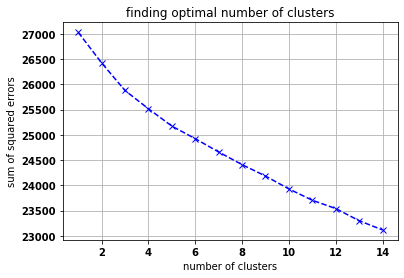

In [30]:
font={'family':'normal','weight':'bold','size':10}
plt.rc('font',**font)
plt.plot(num_cluster,sum_square_dist,'bx--')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.title('finding optimal number of clusters')
plt.grid()

In [31]:
num_clusters=10
km=KMeans(n_clusters=num_clusters,random_state=23)
km.fit(tfidf_matrix)
clusters=km.labels_.tolist()
centers=km.cluster_centers_

In [32]:
#getting cluster centers
km.cluster_centers_.argsort()[:,::-1]

array([[  0,   1, 108, ...,  88,  58,  85],
       [ 85,   0, 101, ..., 113,  12,  94],
       [  0,  55,  56, ...,  12, 113,  85],
       ...,
       [  5,  25,   0, ...,  22,  13,  94],
       [ 93,  75,   0, ...,  12,  94,  13],
       [ 80,   0,  82, ...,  68,  93,  32]], dtype=int64)

In [35]:
# seeing top words in a cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("\n")
    print("Top words in Cluster-%d :" % i, end='')
    print("\n")
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
        print('%s' % terms[ind].split(' '), end=',')

Top terms per cluster:


Top words in Cluster-0 :

['039'],['039', 've'],['ve'],['take'],['years'],['effect'],['months'],['get'],['time'],['start'],

Top words in Cluster-1 :

['quot'],['039'],['take'],['feel'],['years'],['day'],['work'],['effect'],['time'],['like'],

Top words in Cluster-2 :

['039'],['it'],['it', '039'],['don', '039'],['don'],['feel'],['take'],['like'],['day'],['work'],

Top words in Cluster-3 :

['medicine'],['take'],['effect'],['work'],['039'],['years'],['help'],['day'],['pain'],['time'],

Top words in Cluster-4 :

['pain'],['039'],['take'],['day'],['work'],['help'],['severe'],['go'],['effect'],['doctor'],

Top words in Cluster-5 :

['work'],['great'],['039'],['take'],['effect'],['try'],['years'],['medication'],['time'],['day'],

Top words in Cluster-6 :

['take'],['effect'],['day'],['start'],['years'],['feel'],['039'],['go'],['medication'],['days'],

Top words in Cluster-7 :

['anxiety'],['depression'],['039'],['feel'],['take'],['help'],['life'],['effect'],['start

In [42]:
df_train['review_group']=['cluster_'+str(x) for x in clusters]
columns_to_drop=['name_of_drug','review_by_patient']
#df_train.drop(columns_to_drop,axis=1,inplace=True)

In [41]:
df_train.head()

,use_case_for_drug,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,drug_frequency,review_group
patient_id,,,,,,,
206461,rare,9,1547,27,8.022969,15,cluster_6
95260,ADHD,8,793,192,7.858458,23,cluster_6
92703,Birth Control,5,659,17,6.341969,2,cluster_9
35696,Opiate Dependence,9,3199,37,6.590176,88,cluster_2
155963,Benign Prostatic Hyperplasia,2,2834,43,6.144782,68,cluster_5


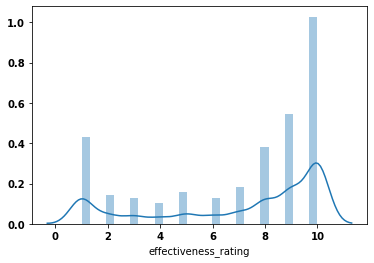

In [43]:
sns.distplot(df_train['effectiveness_rating'])

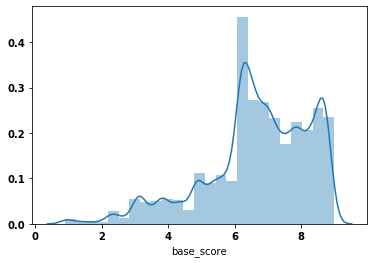

In [44]:
sns.distplot(df_train['base_score'],bins=25)

In [45]:
df_train['review_group'].value_counts()


cluster_6    9394
cluster_9    4165
cluster_2    4086
cluster_0    3440
cluster_4    2500
cluster_5    1969
cluster_7    1875
cluster_3    1752
cluster_8    1557
cluster_1    1427
Name: review_group, dtype: int64

### Train-Test Split

In [46]:
X,y=df_train.loc[:,df_train.columns!='base_score'],df_train['base_score']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=123)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(28948, 6) (28948,)
(3217, 6) (3217,)


In [47]:
numattr=['drug_approved_by_UIC','number_of_times_prescribed','drug_frequency']
catattr=X_train.columns.difference(numattr)
df_train[catattr]=df_train[catattr].astype('category')

In [48]:
X_train.head()

,use_case_for_drug,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,drug_frequency,review_group
patient_id,,,,,,
19854,Pain,9,252,84,112,cluster_4
160128,rare,8,3129,4,12,cluster_9
231525,Depression,1,2899,36,124,cluster_2
191799,Birth Control,10,3414,12,166,cluster_9
219764,Pain,10,3270,77,152,cluster_8


### Model Building

In [50]:
# Pipeline
num_transformer=Pipeline(steps=[
    ('scaler',StandardScaler())
])
cat_transformer=Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,numattr),
    ('cat',cat_transformer,catattr)
])
preprocessor.fit(X_train)
X_train1=preprocessor.transform(X_train)
X_test1=preprocessor.transform(X_test)

In [67]:
X_train1.shape

(28948, 176)

In [52]:
from sklearn.linear_model import LinearRegression
reg1=LinearRegression()

reg1.fit(X_train1,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
pred_train=reg1.predict(X_train1)
pred_test=reg1.predict(X_test1)
train_score=1-sqrt(mean_squared_error(y_train,pred_train))
test_score=1-sqrt(mean_squared_error(y_test,pred_test))
print('train_score:',train_score)
print('test_score:',test_score)

train_score: -0.14771973251894455
test_score: -0.13280681773893277


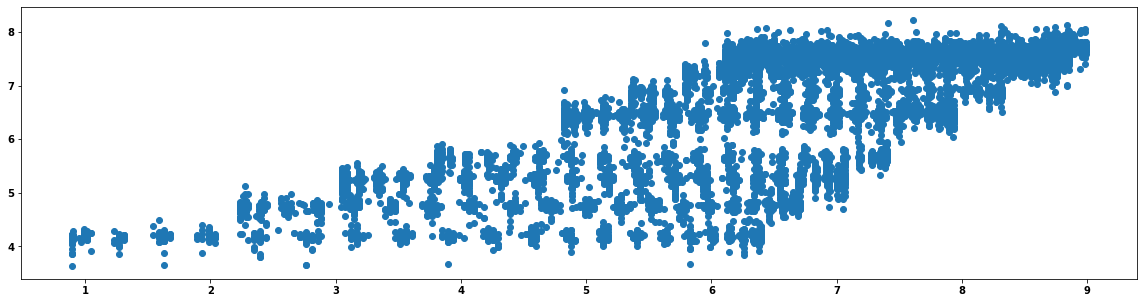

In [66]:
plt.figure(figsize=(20,5))
plt.scatter(y_train,pred_train)

In [60]:
from sklearn.neighbors import KNeighborsRegressor
reg2=KNeighborsRegressor(n_neighbors=6,n_jobs=3)
reg2.fit(X_train1,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=3, n_neighbors=6, p=2,
                    weights='uniform')

In [61]:
pred_train=reg2.predict(X_train1)
pred_test=reg2.predict(X_test1)
train_score=1-sqrt(mean_squared_error(y_train,pred_train))
test_score=1-sqrt(mean_squared_error(y_test,pred_test))
print('train_score:',train_score)
print('test_score:',test_score)

train_score: -0.04456303617251067
test_score: -0.22968145678123109


In [70]:
from sklearn.tree import DecisionTreeRegressor
reg3=DecisionTreeRegressor(random_state=23)
param_grid={'max_depth':[20,40,60,80],
           'min_samples_split':[2,4,6],
           'min_samples_leaf':[2,4,6]}
kf=KFold(n_splits=3)
dt_grid=GridSearchCV(reg3,param_grid=param_grid,cv=kf)

In [71]:
%%time
dt_grid.fit(X_train1,y_train)

Wall time: 29.8 s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=23, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [20, 40, 60, 80],
                         'min_samples_leaf': [2, 4, 6],
                         'm

In [72]:
pred_train=dt_grid.predict(X_train1)
pred_test=dt_grid.predict(X_test1)
train_score=1-sqrt(mean_squared_error(y_train,pred_train))
test_score=1-sqrt(mean_squared_error(y_test,pred_test))
print('train_score:',train_score)
print('test_score:',test_score)

train_score: 0.8582328399293254
test_score: 0.7410206887472902


Text(0, 0.5, 'predicted_values')

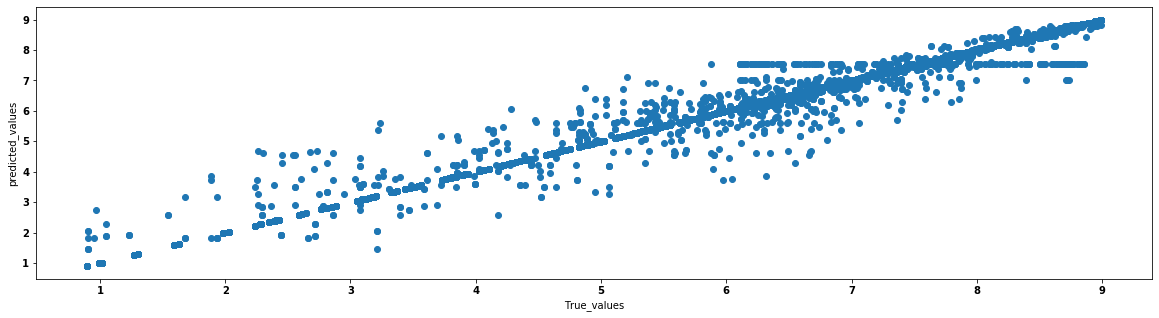

In [74]:
plt.figure(figsize=(20,5))
plt.scatter(y_train,pred_train)
plt.xlabel('True_values')
plt.ylabel('predicted_values')

In [76]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(random_state=23,n_jobs=3)
param_grid={'max_depth':[20,40,60,80],
           'min_samples_split':[2,4,6],
           'min_samples_leaf':[2,4,6],
           'n_estimators':[100,200,400]}
kf=KFold(n_splits=3)
rf_grid=GridSearchCV(rf,param_grid=param_grid,cv=kf)

In [77]:
%%time
rf_grid.fit(X_train1,y_train)

Wall time: 1h 38min 5s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=3,
                                             oob_score=False, random_state=23,
                                             verbose

In [79]:
pred_train=rf_grid.predict(X_train1)
pred_test=rf_grid.predict(X_test1)
train_score=1-sqrt(mean_squared_error(y_train,pred_train))
test_score=1-sqrt(mean_squared_error(y_test,pred_test))
print('train_score:',train_score)
print('test_score:',test_score)

train_score: 0.8903417049602995
test_score: 0.78075241698608


Text(0, 0.5, 'predicted_values')

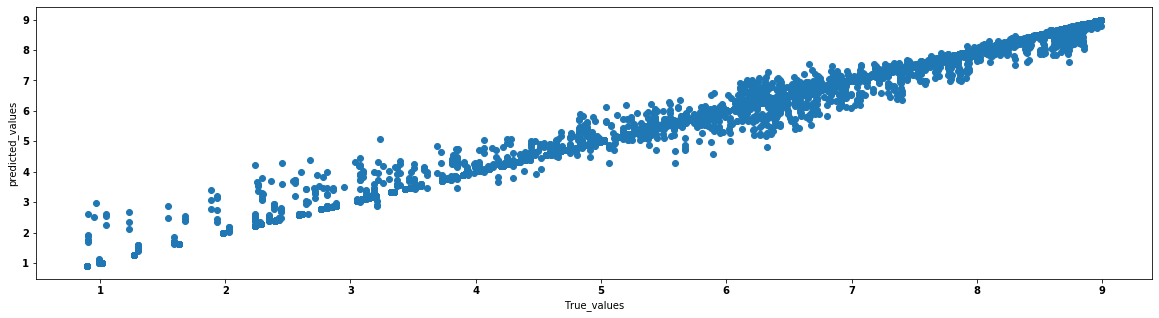

In [80]:
plt.figure(figsize=(20,5))
plt.scatter(y_train,pred_train)
plt.xlabel('True_values')
plt.ylabel('predicted_values')

In [85]:
''''''import joblib
filename='rf_model.sav'
joblib.dump(rf_grid,filename)

['rf_model.sav']

In [87]:
rf_model=joblib.load('rf_model.sav')


array([8.19329814, 8.75684881, 3.81286603, ..., 7.60646542, 6.25662356,
       6.33531735])